### Dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt 

%matplotlib inline

df = pd.read_csv('../datasets/course.csv')

categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
numerical_columns = [col for col in df.columns if df[col].dtype != 'object' and col != 'converted']

df[categorical_columns] = df[categorical_columns].fillna('NA')
df[numerical_columns] = df[numerical_columns].fillna(0)


### Split the dataset into train, validation, and test sets

In [3]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)  
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values

del df_train['converted']
del df_val['converted']
del df_test['converted']

### One hot encoding

In [4]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)


### Train the model using Logistic Regression

In [5]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_val)[:,1]
y_pred = model.predict(X_val)



### Accuracy

In [6]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred_prob >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.584
0.05 0.584
0.10 0.584
0.15 0.584
0.20 0.584
0.25 0.584
0.30 0.594
0.35 0.601
0.40 0.642
0.45 0.679
0.50 0.700
0.55 0.747
0.60 0.747
0.65 0.734
0.70 0.693
0.75 0.655
0.80 0.614
0.85 0.567
0.90 0.495
0.95 0.433
1.00 0.416


### Confusion matrix

In [7]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
t = 0.55
predict_positive = (y_pred_prob >= t)
predict_negative = (y_pred_prob < t)
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix


array([[ 60,  62],
       [ 12, 159]])

### Precision  and Recall
Precision = TP / (TP + FP)  
Recall    = TP / (TP + FN)

In [8]:
p = tp / (tp + fp)
r = tp / (tp + fn)
p, r    

(np.float64(0.7194570135746606), np.float64(0.9298245614035088))

### ROC and AUC
True Postive Rate (TPR)   = Sensitivity = Recall  = TP / (TP + FN), we need to maximize this metric.    
False Positive Rate (FPR) = 1 - Specificity = FP / (FP +TN)  we need to minimize this metric.   
ROC (Receiver Operator Characteristic) curve considers Recall and FPR under all the possible thresholds and makes it easier to identify best threshold.   
AUC (Area Under Curve) makes it easier to compare one ROC curve to another.


In [9]:
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
tpr, fpr

(np.float64(0.9298245614035088), np.float64(0.5081967213114754))

<Axes: xlabel='fpr'>

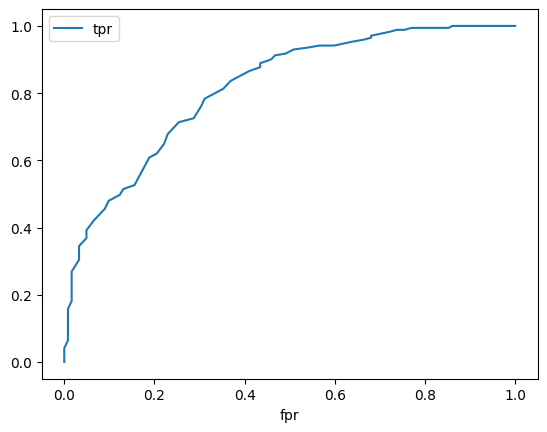

In [10]:
# Manual method to plot ROC
scores = []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    predict_positive = (y_pred_prob >= t)
    predict_negative = (y_pred_prob < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    scores.append((t, tpr, fpr))
columns = ['threshold', 'tpr', 'fpr']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.plot(x='fpr', y='tpr')

Text(0.5, 1.0, 'ROC curve')

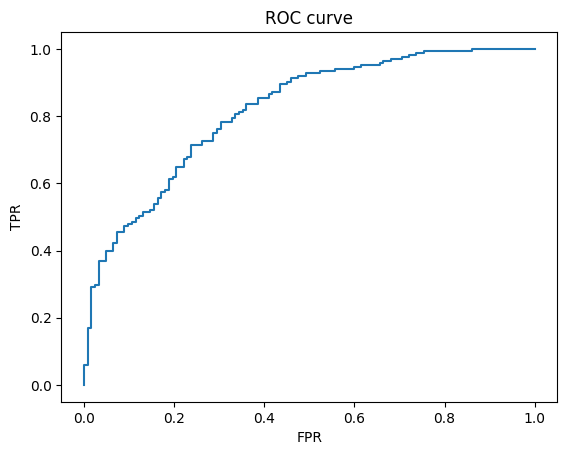

In [11]:
# Using sklearn to plot ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlabel('FPR')   
plt.ylabel('TPR')
plt.title('ROC curve')  


In [12]:
roc_auc_score(y_val, y_pred_prob)

0.8171316268814112

In [ ]:
"""
For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.
"""

for col in numerical_columns:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col]) # negative correlation becomes positive.
    print('%s: %f' % (col, auc))

number_of_courses_viewed: 0.763568
annual_income: 0.551958
interaction_count: 0.738270
lead_score: 0.614499
